In [1]:
import os
import mne
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from scipy.signal import hilbert
from scipy.signal import spectrogram
from sklearn.preprocessing import StandardScaler
from scipy.fft import fft, fftfreq
from sklearn.metrics import mutual_info_score
from PyEMD import EMD
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from scipy.interpolate import CubicSpline
import pywt
from sklearn.decomposition import FastICA, PCA
from EMD import EMD  

In [2]:
# Caminho para o diretório raiz dos dados
base_path = '/Users/analuiza/Documents/codes/templedata/tuh_eeg_epilepsy/v1.0.0/edf'

In [3]:
# Função para carregar metadados e preparar dados para leitura sob demanda
def prepare_eeg_data(base_path):
    file_index = []  # Lista de caminhos e categorias
    for category in ['epilepsy', 'no_epilepsy']:
        category_path = os.path.join(base_path, category)
        if not os.path.exists(category_path):
            print(f"Diretório não encontrado: {category_path}")
            continue

        # Percorre a estrutura de pastas
        for root, dirs, files in os.walk(category_path):
            for file in files:
                if file.lower().endswith('.edf'):
                    file_index.append({
                        'file_path': os.path.join(root, file),
                        'category': category
                    })
    return file_index

# Função para carregar e processar um único arquivo (sob demanda)
def process_single_file(file_info):
    try:
        # Carregar apenas metadados do arquivo
        raw = mne.io.read_raw_edf(file_info['file_path'], preload=False)
        print(f"Arquivo carregado: {file_info['file_path']}")
        print(f"Categoria: {file_info['category']}")
        print(f"Informações do arquivo: {raw.info}")
        return raw
    except Exception as e:
        print(f"Erro ao carregar {file_info['file_path']}: {e}")
        return None

# Preparar os dados
file_index = prepare_eeg_data(base_path)

# Processar apenas o primeiro arquivo como exemplo
if file_index:
    raw_data = process_single_file(file_index[0])  # Carregar o primeiro arquivo
else:
    print("Nenhum arquivo encontrado.")

Extracting EDF parameters from /Users/analuiza/Documents/codes/templedata/tuh_eeg_epilepsy/v1.0.0/edf/epilepsy/03_tcp_ar_a/076/00007656/s010_2011_03_13/00007656_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Arquivo carregado: /Users/analuiza/Documents/codes/templedata/tuh_eeg_epilepsy/v1.0.0/edf/epilepsy/03_tcp_ar_a/076/00007656/s010_2011_03_13/00007656_s010_t000.edf
Categoria: epilepsy
Informações do arquivo: <Info | 8 non-empty values
 bads: []
 ch_names: EEG FP1-REF, EEG FP2-REF, EEG F3-REF, EEG F4-REF, EEG C3-REF, ...
 chs: 34 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2011-03-13 12:26:40 UTC
 nchan: 34
 projs: []
 sfreq: 256.0 Hz
 subject_info: <subject_info | his_id: 00007656, sex: 2, last_name: 00007656, birthday: 1948-01-01>
>


In [ ]:
'''
import numpy as np
import scipy.io as sio
import mne
import os

# Nome do canal para visualização
channel_name = 'EEG FP1-REF'  # Confirme o nome correto com `print(raw_data.ch_names)`

# Verificar se o canal está na lista
if channel_name in raw_data.ch_names:
    # Extrair índice do canal
    channel_index = raw_data.ch_names.index(channel_name)
    
    # Obter os dados do canal (garantir que seja um vetor 1D)
    channel_data = raw_data.get_data(picks=[channel_index]).squeeze()  # Remove dimensões extras

    # Salvar como .mat
    mat_file = "EEG_FP1-REF.mat"
    sio.savemat(mat_file, {"EEG_signal": channel_data})

    print(f"Arquivo salvo como {mat_file} com sucesso!")
else:
    print(f"Erro: Canal '{channel_name}' não encontrado. Verifique com `print(raw_data.ch_names)`.")'
'''

Arquivo salvo como EEG_FP1-REF.mat com sucesso!


### O registro carregado para a visualização a seguir é de epilepsia da pasta 3 do paciente 76 sendo ele o registro: **00007656_s010_t000.edf** e ele contém **34 canais**, incluindo EEG FP1-REF, EEG FP2-REF, etc.

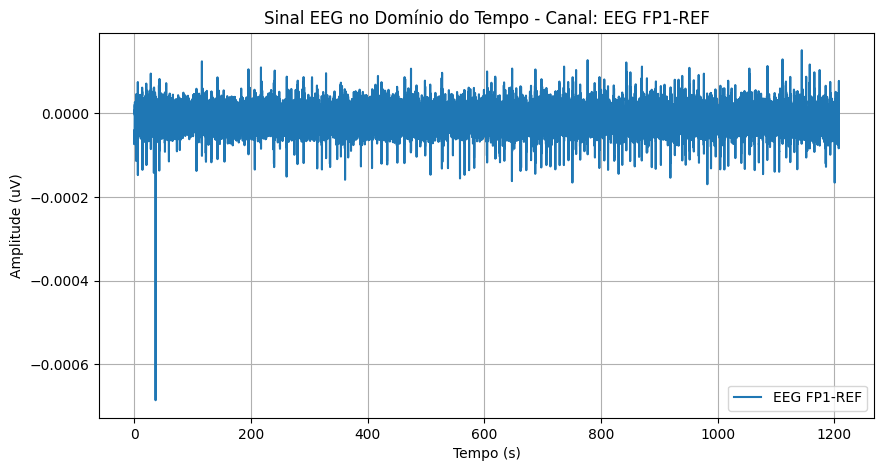

In [4]:
# Nome do canal para visualização
channel_name = 'EEG FP1-REF'

# Extrair índice do canal
channel_index = raw_data.ch_names.index(channel_name)

# Extrair dados do canal
channel_data = raw_data.get_data(picks=[channel_index])  # Dados do canal
time = raw_data.times  # Tempo correspondente

# Visualização no domínio do tempo
plt.figure(figsize=(10, 5))
plt.plot(time, channel_data[0], label=channel_name)
plt.title(f'Sinal EEG no Domínio do Tempo - Canal: {channel_name}')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude (uV)')
plt.legend()
plt.grid(True)
plt.show()

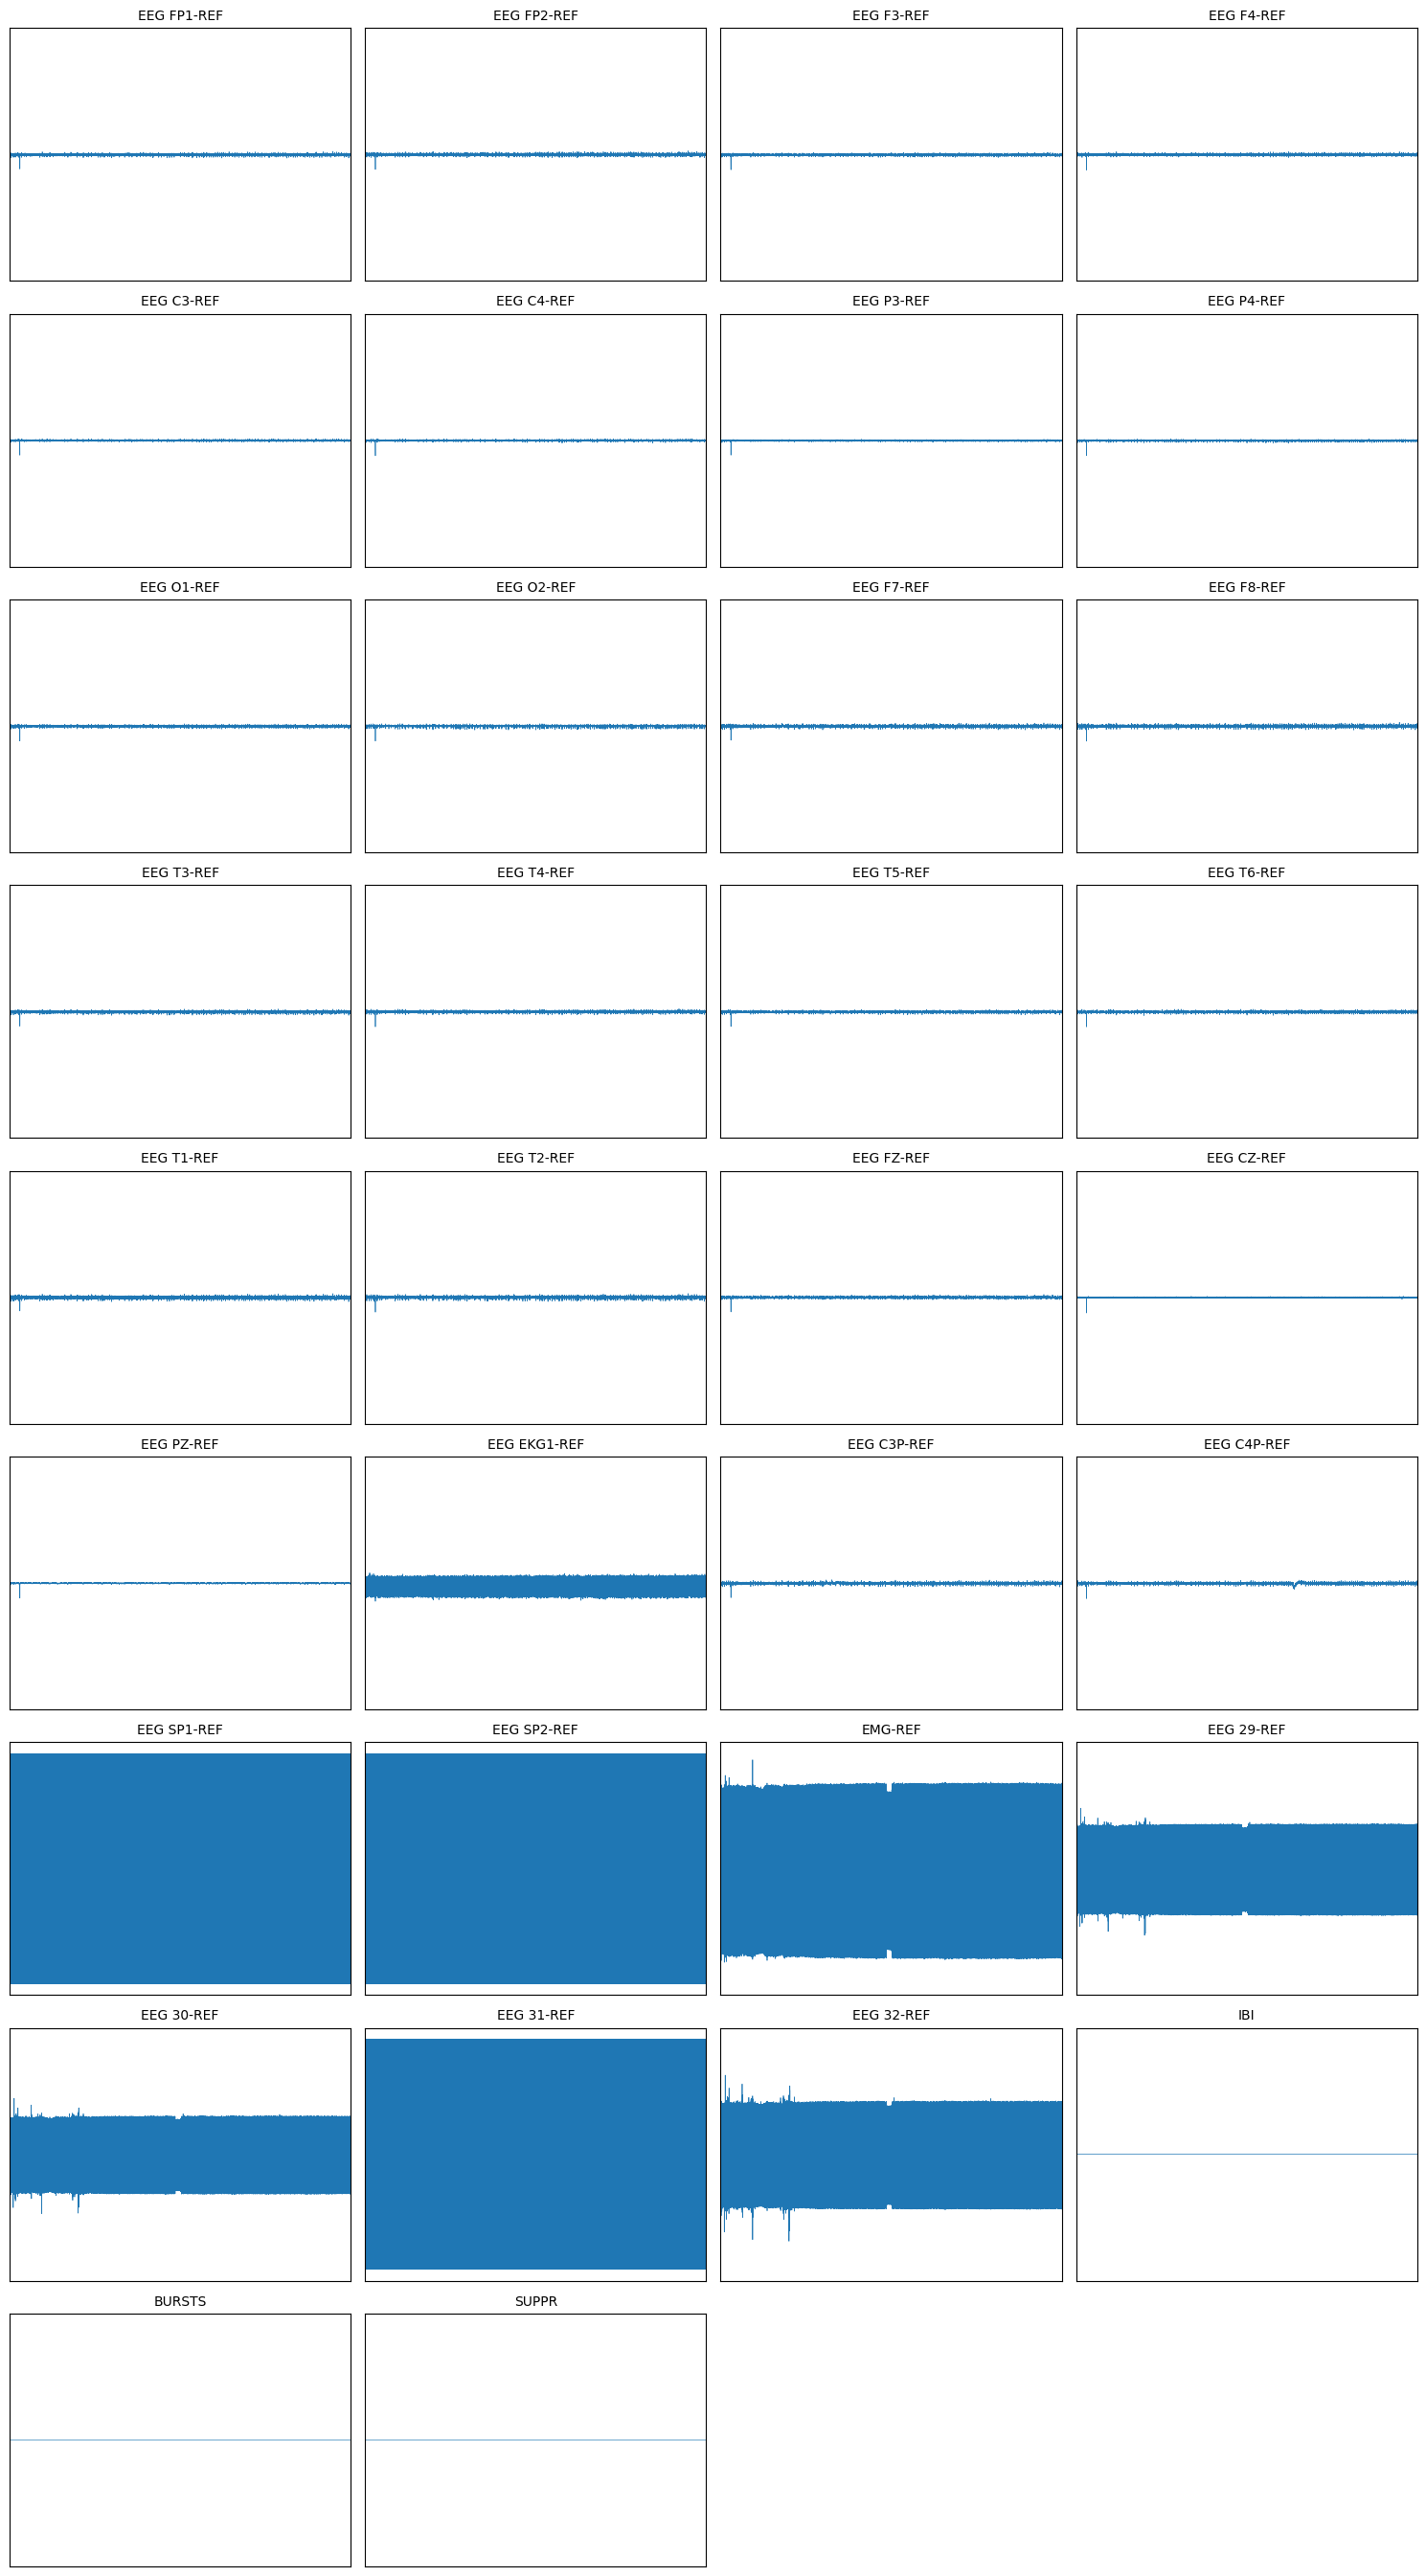

In [5]:
# Extrair os dados de todos os canais e o vetor de tempo
eeg_data = raw_data.get_data()  # Matriz [n_canais x n_amostras]
time = raw_data.times  # Tempo correspondente
channel_names = raw_data.ch_names  # Nomes dos canais

# Configurações do grid
n_channels = len(channel_names)  # Número de canais
n_rows = int(np.ceil(n_channels / 4))  # Número de linhas no grid (4 colunas por padrão)
fig, axes = plt.subplots(n_rows, 4, figsize=(15, n_rows * 3), sharex=True, sharey=True)

# Adicionar cada canal ao grid
for i, ax in enumerate(axes.flat):
    if i < n_channels:
        ax.plot(time, eeg_data[i], lw=0.5)
        ax.set_title(channel_names[i], fontsize=10)
        ax.set_xlim([time[0], time[-1]])
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        # Remove eixos extras
        ax.axis('off')

# Ajustar layout
fig.tight_layout()
plt.show()

Processamento desse registro:

In [6]:
# Configurações para armazenamento dos dados processados
output_dir = '/Users/analuiza/Documents/codes/templedata/00007656_s010_t000_processed_data'
os.makedirs(output_dir, exist_ok=True)


In [8]:
# Lista de canais a serem excluídos
excluded_channels = [
    'EEG_EKG1-REF', 'EEG_SP1-REF', 'EEG_SP2-REF', 'EMG-REF', 
    'EEG_29-REF', 'EEG_30-REF', 'EEG_31-REF', 'EEG_32-REF',
    'IBI', 'BURSTS', 'SUPPR'
]

# Tempo para excluir o ruído inicial (em segundos)
time_to_exclude = 200  # Ajuste conforme necessário

# Função para pré-processamento SEM alterar os dados brutos
def preprocess_eeg(raw_data, output_dir):
    # Criar uma cópia dos dados para não modificar o original
    raw_processed = raw_data.copy()
    
    # Certificar que os dados estão carregados na memória
    raw_processed.load_data()
    print("Dados carregados na memória.")

    # 1. Filtragem com band-pass (0.5 - 120 Hz)
    raw_processed.filter(0.5, 120., fir_design='firwin')
    print("Filtragem aplicada (0.5-120 Hz).")

    # 2. Aplicar filtro Notch (58.5 - 61 Hz)
    raw_processed.notch_filter(freqs=[59.75], notch_widths=2.5)
    print("Filtro Notch aplicado (58.5 - 61 Hz).")

    # 3. Ajustar nomes dos canais para garantir exclusão correta
    adjusted_excluded_channels = [ch.replace('_', ' ') for ch in excluded_channels]

    # Filtrar apenas os canais que realmente existem no arquivo
    channels_to_remove = [ch for ch in adjusted_excluded_channels if ch in raw_processed.ch_names]

    if channels_to_remove:
        print(f"Canais que serão removidos: {channels_to_remove}")
        raw_processed.drop_channels(channels_to_remove)
    else:
        print("Nenhum dos canais a serem excluídos foi encontrado nos dados.")

    # 4. Excluir ruído inicial
    raw_processed.crop(tmin=time_to_exclude, tmax=None)
    print(f"Primeiros {time_to_exclude} segundos excluídos.")

    # 5. Extrair dados e nomes dos canais restantes
    eeg_data = raw_processed.get_data()
    print(f"Formato dos dados após processamento: {eeg_data.shape}")

    channel_names = raw_processed.ch_names
    print(f"Canais disponíveis após processamento: {channel_names}")

    # 6. Normalização
    scaler = StandardScaler()
    eeg_data_normalized = scaler.fit_transform(eeg_data.T).T
    print("Normalização aplicada (zero-mean, unit-variance).")

    # 7. Salvar os sinais processados
    os.makedirs(output_dir, exist_ok=True)
    for i, channel in enumerate(channel_names):
        channel_data = eeg_data_normalized[i]
        output_path = os.path.join(output_dir, f"{channel.replace(' ', '_')}.npy")
        np.save(output_path, channel_data)
        print(f"Sinal processado salvo: {output_path}")

    print(f"Todos os canais foram processados e salvos em {output_dir}.")

In [7]:
# Configuração do diretório de saída
output_dir = '/Users/analuiza/Documents/codes/templedata/00007656_s010_t000_processed_data'

In [9]:
# Executar o pré-processamento
preprocess_eeg(raw_data, output_dir)

Reading 0 ... 309247  =      0.000 ...  1207.996 secs...
Dados carregados na memória.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 8.00 Hz (-6 dB cutoff frequency: 124.00 Hz)
- Filter length: 1691 samples (6.605 s)

Filtragem aplicada (0.5-120 Hz).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 58 - 62 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenua

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtro Notch aplicado (58.5 - 61 Hz).
Canais que serão removidos: ['EEG EKG1-REF', 'EEG SP1-REF', 'EEG SP2-REF', 'EMG-REF', 'EEG 29-REF', 'EEG 30-REF', 'EEG 31-REF', 'EEG 32-REF', 'IBI', 'BURSTS', 'SUPPR']
Primeiros 200 segundos excluídos.
Formato dos dados após processamento: (23, 258048)
Canais disponíveis após processamento: ['EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF', 'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF', 'EEG F7-REF', 'EEG F8-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF', 'EEG T6-REF', 'EEG T1-REF', 'EEG T2-REF', 'EEG FZ-REF', 'EEG CZ-REF', 'EEG PZ-REF', 'EEG C3P-REF', 'EEG C4P-REF']
Normalização aplicada (zero-mean, unit-variance).
Sinal processado salvo: /Users/analuiza/Documents/codes/templedata/00007656_s010_t000_processed_data/EEG_FP1-REF.npy
Sinal processado salvo: /Users/analuiza/Documents/codes/templedata/00007656_s010_t000_processed_data/EEG_FP2-REF.npy
Sinal processado salvo: /Users/analuiza/Documents/codes/tem

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


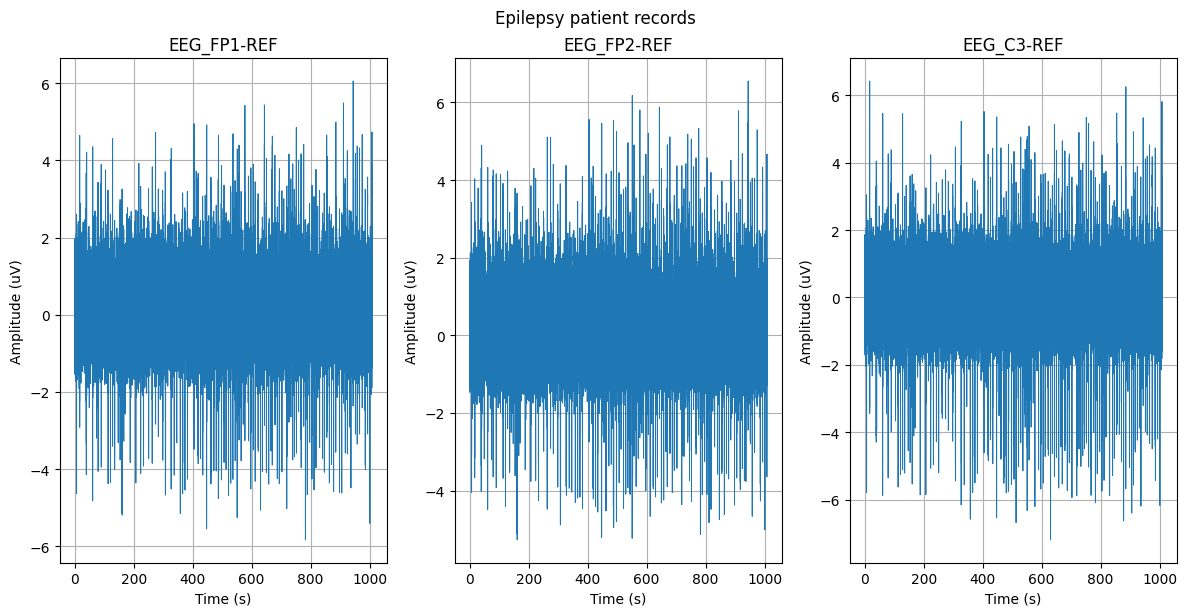

In [7]:
# Lista dos arquivos processados para visualização
signals_to_plot = [
    '/Users/analuiza/Documents/codes/templedata/00007656_s010_t000_processed_data/EEG_FP1-REF.npy',
    '/Users/analuiza/Documents/codes/templedata/00007656_s010_t000_processed_data/EEG_FP2-REF.npy',
    '/Users/analuiza/Documents/codes/templedata/00007656_s010_t000_processed_data/EEG_C3-REF.npy',
]

# Parâmetros do EEG
sfreq = 256.0  # Frequência de amostragem (ajustar conforme o registro)
time = np.arange(0, len(np.load(signals_to_plot[0])) / sfreq, 1 / sfreq)  # Vetor de tempo

# Função para calcular o espectro de potência
def calculate_power_spectrum(signal, sfreq):
    n = len(signal)
    freq = fftfreq(n, d=1/sfreq)[:n//2]  # Apenas frequências positivas
    spectrum = np.abs(fft(signal))[:n//2]  # Magnitude do espectro
    return freq, spectrum

# Grid 1: Domínio do Tempo
plt.figure(figsize=(12, 6))
for i, file in enumerate(signals_to_plot):
    signal = np.load(file)
    plt.subplot(1, 3, i + 1)
    plt.plot(time, signal, lw=0.7)
    plt.title(file.split('/')[-1].replace('.npy', ''))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (uV)')
    plt.grid(True)
plt.tight_layout()
plt.suptitle('Epilepsy patient records', y=1.02)
plt.show()

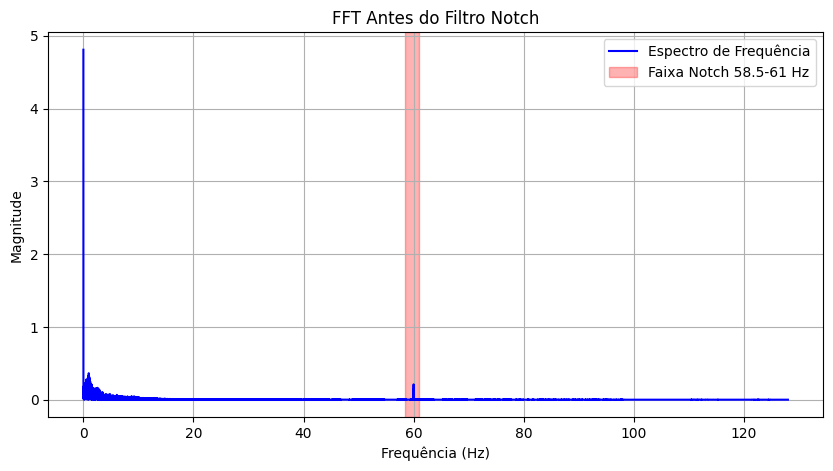

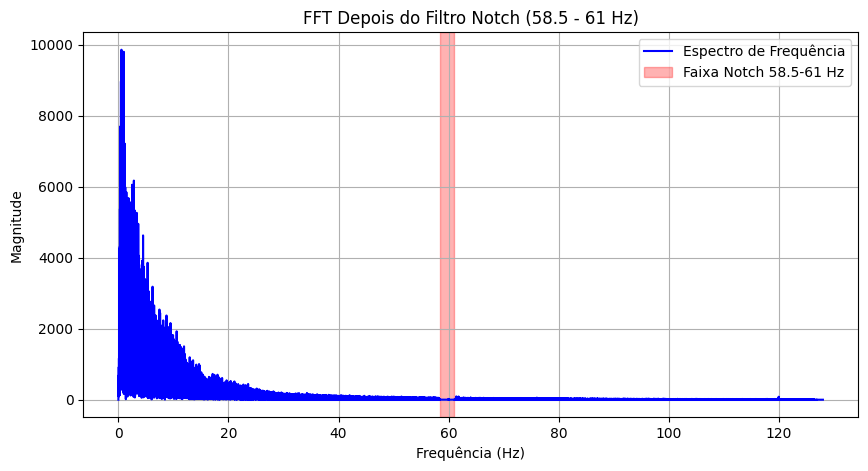

In [8]:
# Arquivo original (antes do processamento)
raw_data_original = raw_data.copy()  # Mantém os dados originais carregados

# Diretório dos dados processados
processed_files = [f for f in os.listdir(output_dir) if f.endswith('.npy')]

# Carregar os dados processados
processed_data = []
channel_names = []
for file in processed_files:
    channel_data = np.load(os.path.join(output_dir, file))
    processed_data.append(channel_data)
    channel_names.append(file.replace('.npy', '').replace('_', ' '))  # Ajusta nomes

# Converter lista para array numpy (mesma estrutura que MNE usa)
raw_data_filtrado = np.array(processed_data)

# Frequência de amostragem
fs = 256  # Atualize com a real frequência do EEG

# ** Função para Plotar FFT **
def plot_fft(signal, fs, title="Espectro de Frequência"):
    """
    Calcula e plota a FFT do sinal EEG.
    
    Parâmetros:
    - signal: dados do EEG para um único canal.
    - fs: frequência de amostragem.
    - title: título do gráfico.
    """
    # Calcular FFT
    N = len(signal)
    freq = np.linspace(0, fs / 2, N // 2)  # Eixo de frequência
    spectrum = np.abs(fft(signal))[:N // 2]  # Magnitude da FFT

    # Plotar
    plt.figure(figsize=(10, 5))
    plt.plot(freq, spectrum, color="b", label="Espectro de Frequência")
    plt.axvspan(58.5, 61, color='red', alpha=0.3, label="Faixa Notch 58.5-61 Hz")  # Destacar notch
    plt.xlabel("Frequência (Hz)")
    plt.ylabel("Magnitude")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

# ** Plotar FFT antes e depois do filtro **
channel_index = 0  # Escolha o canal a visualizar

# Antes do filtro
plot_fft(raw_data_original.get_data()[channel_index], fs, title="FFT Antes do Filtro Notch")
plot_fft(raw_data_filtrado[channel_index], fs, title="FFT Depois do Filtro Notch (58.5 - 61 Hz)")

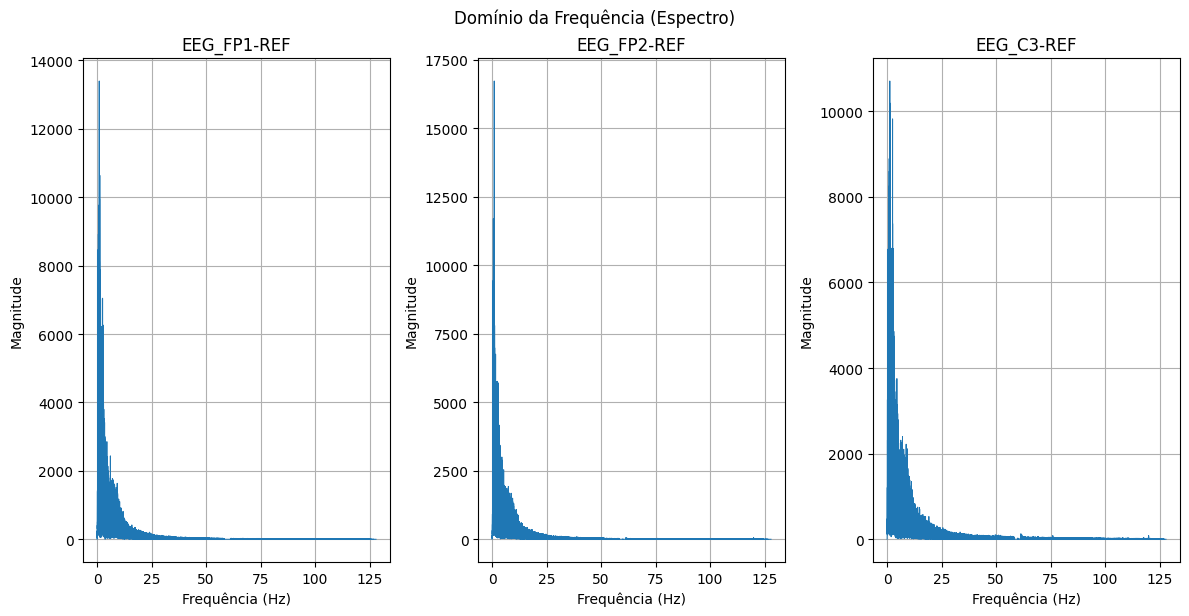

In [9]:
# Grid 2: Domínio da Frequência
plt.figure(figsize=(12, 6))
for i, file in enumerate(signals_to_plot):
    signal = np.load(file)
    freq, spectrum = calculate_power_spectrum(signal, sfreq)
    plt.subplot(1, 3, i + 1)
    plt.plot(freq, spectrum, lw=0.7)
    plt.title(file.split('/')[-1].replace('.npy', ''))
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('Magnitude')
    plt.grid(True)
plt.tight_layout()
plt.suptitle('Domínio da Frequência (Espectro)', y=1.02)
plt.show()

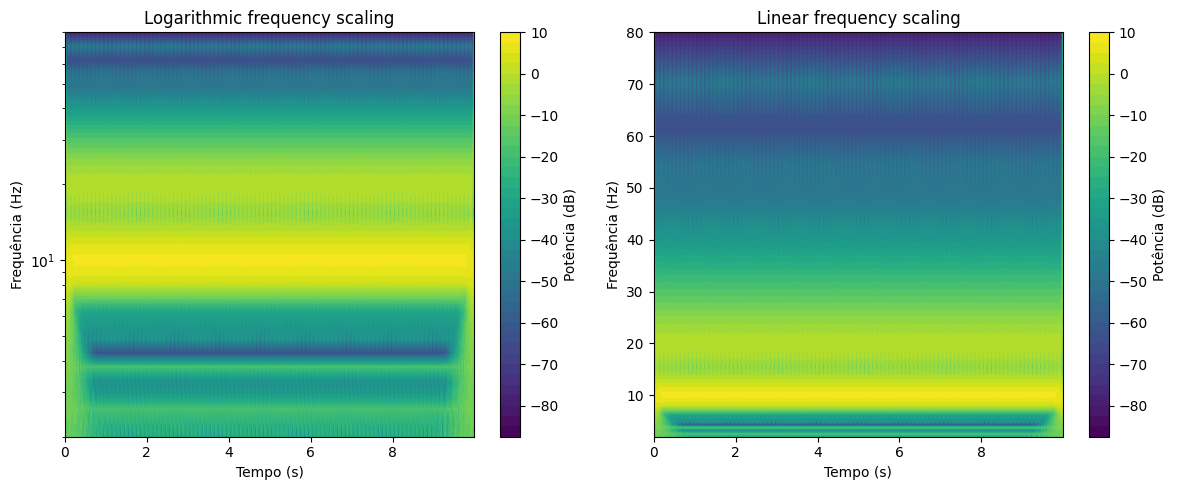

In [10]:
# Função para calcular a Transformada Wavelet Contínua (CWT) baseada no código MATLAB
def compute_wavelet_tf(signal, fs, min_freq=2, max_freq=80, num_frex=30, baseline=(-500, -200)):
    """
    Computa a Transformada Wavelet Contínua (CWT) usando wavelets de Morlet.
    Segue a estrutura do código MATLAB da Figure 13.11.

    Parâmetros:
    - signal: array com o sinal de EEG.
    - fs: taxa de amostragem (Hz).
    - min_freq, max_freq: intervalo de frequências.
    - num_frex: número de frequências a serem avaliadas.
    - baseline: intervalo de tempo para normalização em dB.

    Retorna:
    - freqs: vetor de frequências.
    - time: vetor de tempo.
    - power_db: matriz tempo-frequência (potência em dB).
    """
    # Definir as frequências em escala logarítmica como no MATLAB
    freqs = np.logspace(np.log10(min_freq), np.log10(max_freq), num_frex)
    
    # Definir os valores de sigma (s) da wavelet baseados no MATLAB
    s_values = np.logspace(np.log10(3), np.log10(10), num_frex) / (2 * np.pi * freqs)

    # Criar matriz de potência (frequências x tempo)
    power = np.zeros((num_frex, len(signal)))

    for i, (f, s) in enumerate(zip(freqs, s_values)):
        # Aplicando a Transformada Wavelet Contínua
        scales = fs / f  # Escala para a wavelet de Morlet
        coeffs, _ = pywt.cwt(signal, scales, 'cmor1.5-1.0', sampling_period=1/fs)
        power[i, :] = np.abs(coeffs)**2

    # Vetor de tempo em segundos
    time = np.arange(len(signal)) / fs

    # Normalização em dB usando um baseline
    baseline_idx = np.logical_and(time >= baseline[0] / 1000, time <= baseline[1] / 1000)

    # Evitar erros se o baseline estiver fora do range
    if np.any(baseline_idx):
        baseline_power = np.mean(power[:, baseline_idx], axis=1, keepdims=True)
        power_db = 10 * np.log10(power / (baseline_power + 1e-10))
    else:
        power_db = 10 * np.log10(power + 1e-10)

    return freqs, time, power_db

# Definir taxa de amostragem real do EEG
fs = 256  # Hz

# Criar um sinal de teste com duas senóides
t = np.linspace(0, 10, fs * 10)  # 10 segundos
signal = np.sin(2 * np.pi * 10 * t) + 0.5 * np.sin(2 * np.pi * 20 * t)

# Computar a CWT para obter a TFR
frequencies, time_points, power_tf = compute_wavelet_tf(signal, fs)

# Criar figura para visualização
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Escala Logarítmica
ax1 = axes[0]
img1 = ax1.contourf(time_points, frequencies, power_tf, 40, cmap='viridis')
ax1.set_yscale('log')
ax1.set_title('Logarithmic frequency scaling')
ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Frequência (Hz)')
fig.colorbar(img1, ax=ax1, label="Potência (dB)")

# Escala Linear
ax2 = axes[1]
img2 = ax2.contourf(time_points, frequencies, power_tf, 40, cmap='viridis')
ax2.set_title('Linear frequency scaling')
ax2.set_xlabel('Tempo (s)')
ax2.set_ylabel('Frequência (Hz)')
fig.colorbar(img2, ax=ax2, label="Potência (dB)")

plt.tight_layout()

# Exibir os gráficos
plt.show()

Carregando: /Users/analuiza/Documents/codes/templedata/00007656_s010_t000_processed_data/EEG_T4-REF.npy


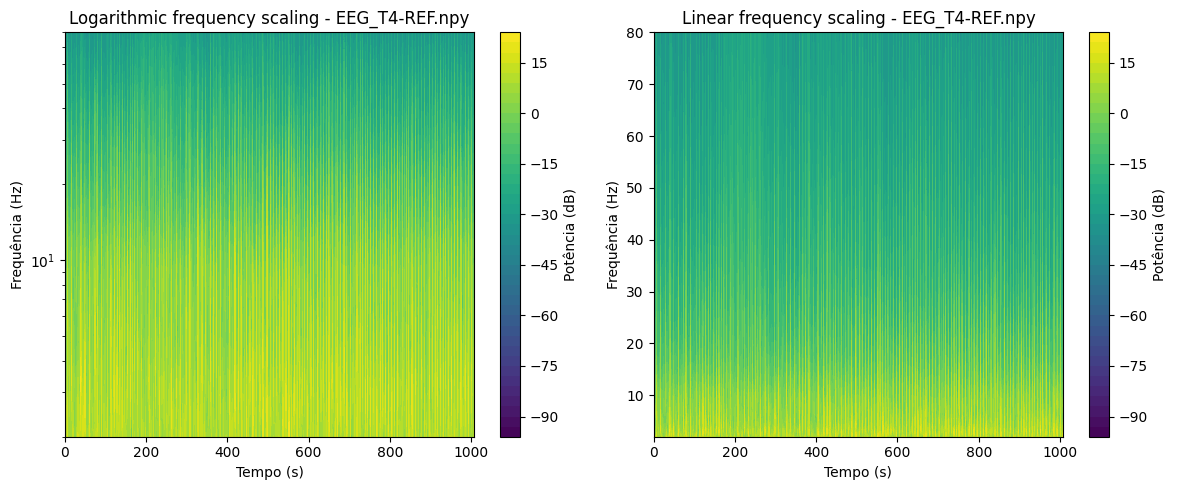

In [15]:
# Listar arquivos disponíveis
processed_files = [f for f in os.listdir(output_dir) if f.endswith('.npy')]

if not processed_files:
    raise FileNotFoundError(f"Nenhum arquivo .npy encontrado em {output_dir}")

# Selecionar um canal para análise (por exemplo, o primeiro da lista)
channel_index = 0  # Pode ser alterado conforme necessário
channel_file = os.path.join(output_dir, processed_files[channel_index])
print(f"Carregando: {channel_file}")

# Carregar os dados do canal
eeg_data = np.load(channel_file)

# Definir taxa de amostragem real do EEG
fs = 256  # Ajuste conforme necessário

# Computar a CWT para obter a TFR
frequencies, time_points, power_tf = compute_wavelet_tf(eeg_data, fs)

# Criar figura para visualização
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Escala Logarítmica
ax1 = axes[0]
img1 = ax1.contourf(time_points, frequencies, power_tf, 40, cmap='viridis')
ax1.set_yscale('log')
ax1.set_title(f'Logarithmic frequency scaling - {processed_files[channel_index]}')
ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Frequência (Hz)')
fig.colorbar(img1, ax=ax1, label="Potência (dB)")

# Escala Linear
ax2 = axes[1]
img2 = ax2.contourf(time_points, frequencies, power_tf, 40, cmap='viridis')
ax2.set_title(f'Linear frequency scaling - {processed_files[channel_index]}')
ax2.set_xlabel('Tempo (s)')
ax2.set_ylabel('Frequência (Hz)')
fig.colorbar(img2, ax=ax2, label="Potência (dB)")

plt.tight_layout()

# Exibir os gráficos
plt.show()

In [12]:
# Função de Decomposição Modal Empírica (EMD)
def EMD(signal, max_imfs=3, min_std=0.3):
    c = signal
    IMFs = []

    for _ in range(max_imfs):
        h = c
        std = 1
        while std > min_std:
            maxenv, minenv = max_min_env(h)
            if isinstance(maxenv, int) or isinstance(minenv, int):
                break
            meanenv = (maxenv + minenv) / 2
            prev_h = h.copy()
            h = h - meanenv
            eps = 1e-8
            std = np.sum(((prev_h - h) ** 2) / (prev_h ** 2 + eps))
        IMFs.append(h.astype(np.float32))  # Reduz memória
        c = c - h

    # Normalizar cada IMF para reduzir a amplitude
    IMFs = np.array(IMFs, dtype=np.float32)
    IMFs /= np.max(np.abs(IMFs), axis=1, keepdims=True)  # Normalização por linha
    return IMFs  

# Função para encontrar os envelopes máximos e mínimos
def max_min_env(signal):
    d = np.diff(signal)
    N = len(signal)
    t = np.arange(N)
    maxmin = []

    for i in range(1, N - 1):
        if d[i - 1] * d[i] < 0:
            maxmin.append(i)
    if len(maxmin) < 2:
        return -1, -1
    maxes = maxmin[::2]
    mins = maxmin[1::2]
    maxenv = np.interp(t, maxes, signal[maxes])
    minenv = np.interp(t, mins, signal[mins])
    return maxenv, minenv

# Função para calcular e salvar o espectro Holo-Hilbert
def holo_hilbert_spectrum(imfs, fs, output_dir, subsample_rate=10):
    """
    Computa o Espectro Holo-Hilbert para os IMFs e salva os gráficos.
    """
    # Aplicar Hilbert Transform para obter envelopes
    envelopes = [np.abs(hilbert(imf)) for imf in imfs]

    # Aplicar logaritmo para reduzir diferenças exponenciais de amplitude
    envelopes = [np.log1p(env) for env in envelopes]  # Correção do erro

    inst_freqs = [
        np.diff(np.unwrap(np.angle(hilbert(imf)))) * fs / (2 * np.pi) for imf in imfs
    ]
    
    freq_bins = 100  # Reduzido para 100 pontos para melhor visualização
    freqs = np.linspace(0, fs / 2, freq_bins)

    for i, (envelope, inst_freq) in enumerate(zip(envelopes, inst_freqs)):
        time_points = len(envelope) - 1

        # Subamostragem para reduzir tamanho
        envelope = envelope[::subsample_rate]
        inst_freq = inst_freq[::subsample_rate]
        time_points = len(envelope)  # Ajustar tamanho

        holo_spectrum = np.zeros((time_points, freq_bins), dtype=np.float32)

        # Processamento em blocos
        for t in range(time_points):
            idx = np.digitize(inst_freq[t], freqs) - 1
            idx = np.clip(idx, 0, freq_bins - 1)  # Evitar valores fora do range
            holo_spectrum[t, idx] = envelope[t] * 0.3  # Reduzindo escala da amplitude

        # Salvar o gráfico para economizar memória
        plt.figure(figsize=(8, 5), dpi=100)
        plt.pcolormesh(
            np.linspace(0, len(envelope) / fs, time_points),
            freqs,
            holo_spectrum.T,
            shading="nearest",
            cmap="magma",
            rasterized=True
        )
        plt.title(f"Holo-Hilbert Spectrum for IMF-{i+1}")
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Hz)")
        plt.colorbar(label="Amplitude")
        plt.tight_layout()
        
        # Salvar a plotagem na pasta correta
        plt.savefig(f"{output_dir}/holo_hilbert_imf_{i+1}.png", dpi=100, bbox_inches='tight')
        plt.close()

# Configurações
fs = 256  # Frequência de amostragem
channel = "EEG_FP1-REF"

# Diretório dos arquivos processados
output_dir = "./00007656_s010_t000_processed_data"
results_dir = "./results"  
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Carregar o arquivo do canal
signal_path = os.path.join(output_dir, f"{channel}.npy")
if not os.path.exists(signal_path):
    raise FileNotFoundError(f"Arquivo {signal_path} não encontrado.")

signal = np.load(signal_path)

# Garantir que o sinal seja 1D
if signal.ndim != 1:
    raise ValueError("O sinal carregado deve ser um vetor 1D.")

# Decomposição Modal Empírica (EMD)
imfs = EMD(signal, max_imfs=5)

# Calcular e salvar o espectro Holo-Hilbert
holo_hilbert_spectrum(imfs, fs, results_dir)

In [10]:
# Definir os diretórios dos arquivos processados
output_dir = "./00007656_s010_t000_processed_data"
results_dir = "./results"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Configurações globais
fs = 256  # Frequência de amostragem
channel = "EEG_FP1-REF"

# Carregar o arquivo de EEG processado
signal_path = os.path.join(output_dir, f"{channel}.npy")
if not os.path.exists(signal_path):
    raise FileNotFoundError(f"Arquivo {signal_path} não encontrado.")

signal = np.load(signal_path)

# Garantir que o sinal seja 1D
if signal.ndim != 1:
    raise ValueError("O sinal carregado deve ser um vetor 1D.")

# **🔹 Aplicar EMD com menos IMFs para acelerar**
max_imfs = 5  # Reduzindo para 5 IMFs para otimização
imfs = EMD(signal, max_imfs=max_imfs)

# **🔹 Função otimizada para Holo-Hilbert**
def holo_hilbert_spectrum(imfs, fs, output_dir, subsample_rate=20, amplitude_scale=0.3):
    """
    Computa o Espectro Holo-Hilbert para os IMFs e salva os gráficos.
    """
    envelopes = [np.abs(hilbert(imf)) for imf in imfs]
    envelopes = [np.log1p(env) for env in envelopes]  # Aplicação de log para estabilizar a amplitude
    inst_freqs = [np.diff(np.unwrap(np.angle(hilbert(imf)))) * fs / (2 * np.pi) for imf in imfs]

    freq_bins = 80  # Reduzindo pontos para otimizar
    freqs = np.linspace(0, fs / 2, freq_bins)

    for i, (envelope, inst_freq) in enumerate(zip(envelopes, inst_freqs)):
        time_points = len(envelope) - 1
        envelope = envelope[::subsample_rate]  # **🔹 Subamostragem mais agressiva**
        inst_freq = inst_freq[::subsample_rate]
        time_points = len(envelope)

        holo_spectrum = np.zeros((time_points, freq_bins), dtype=np.float32)

        # 🔹 **Usando `np.digitize` de forma mais eficiente**
        idxs = np.clip(np.digitize(inst_freq, freqs) - 1, 0, freq_bins - 1)
        np.add.at(holo_spectrum, (np.arange(time_points), idxs), envelope * amplitude_scale)

        # Salvar o gráfico de forma otimizada
        plt.figure(figsize=(8, 5), dpi=100)
        plt.pcolormesh(
            np.linspace(0, len(envelope) / fs, time_points),
            freqs,
            holo_spectrum.T,
            shading="nearest",
            cmap="magma",
            rasterized=True
        )
        plt.title(f"Holo-Hilbert Spectrum - IMF-{i+1}")
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Hz)")
        plt.colorbar(label="Amplitude")
        plt.tight_layout()
        plt.savefig(f"{output_dir}/holo_hilbert_imf_{i+1}.png", dpi=100, bbox_inches='tight')
        plt.close()

# **🔹 Rodar versão otimizada**
holo_hilbert_spectrum(imfs, fs, results_dir)

print("✅ Processamento Holo-Hilbert concluído com sucesso!")

✅ Processamento Holo-Hilbert concluído com sucesso!


# Processamento Extra

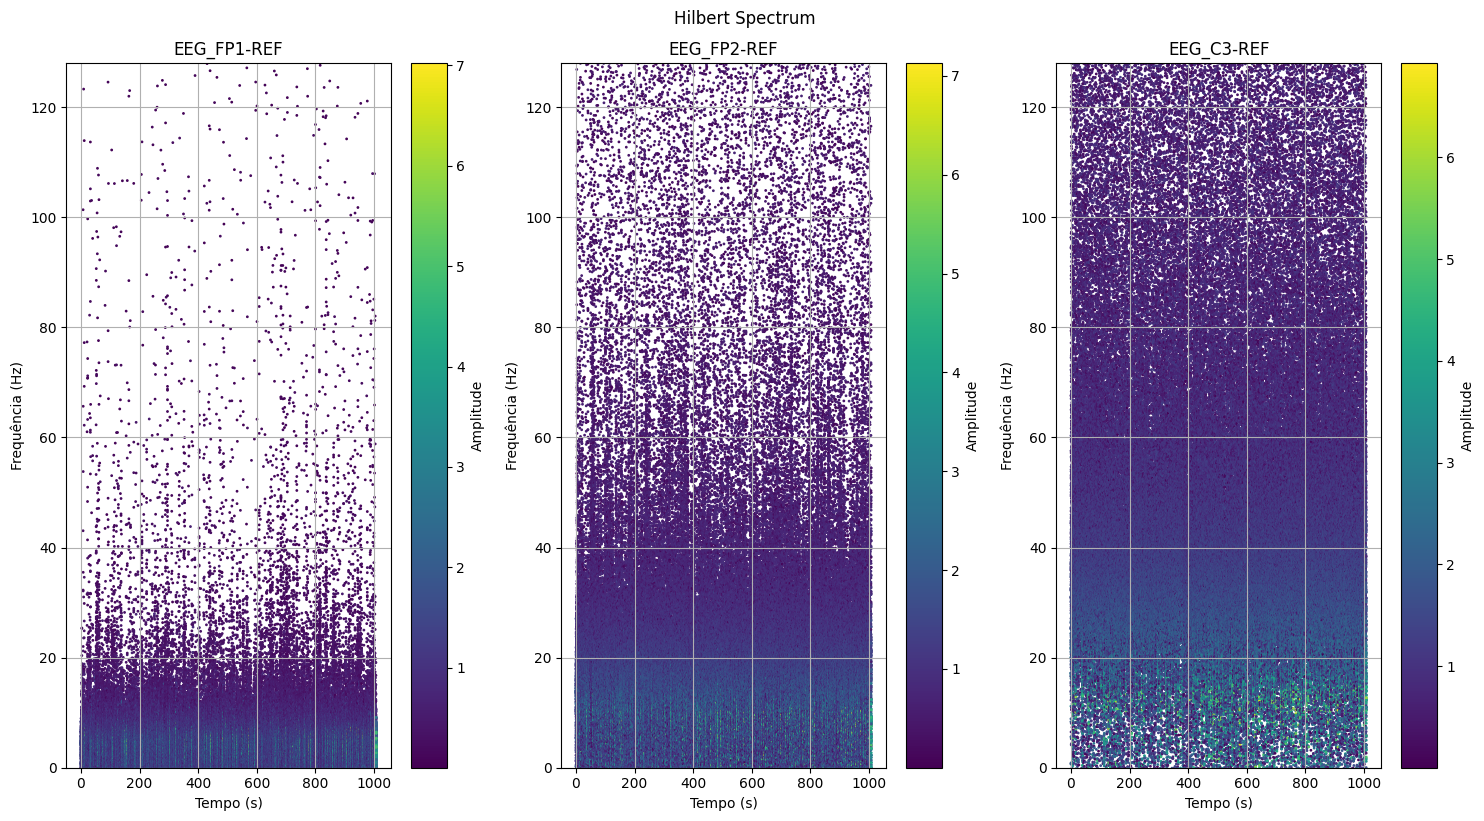

In [30]:
# Parâmetros do EEG
sfreq = 256.0  # Frequência de amostragem (ajustar conforme o registro)
time = np.arange(0, len(np.load(signals_to_plot[0])) / sfreq, 1 / sfreq)  # Vetor de tempo

# Função para calcular o Hilbert Spectrum
def calculate_hilbert_spectrum(signal, sfreq):
    analytic_signal = hilbert(signal)  # Transformada de Hilbert
    amplitude_envelope = np.abs(analytic_signal)  # Envelope do sinal
    instantaneous_phase = np.angle(analytic_signal)  # Fase instantânea
    instantaneous_frequency = np.diff(np.unwrap(instantaneous_phase)) / (2.0 * np.pi) * sfreq
    return amplitude_envelope[:-1], instantaneous_frequency

# Grid: Hilbert Spectrum
plt.figure(figsize=(15, 8))
for i, file in enumerate(signals_to_plot):
    signal = np.load(file)
    amplitude_envelope, instantaneous_frequency = calculate_hilbert_spectrum(signal, sfreq)
    
    # Criar o espectrograma com frequência e amplitude
    plt.subplot(1, 3, i + 1)
    plt.scatter(time[:-1], instantaneous_frequency, c=amplitude_envelope, cmap='viridis', s=1)
    plt.colorbar(label='Amplitude')
    plt.title(file.split('/')[-1].replace('.npy', ''))
    plt.xlabel('Tempo (s)')
    plt.ylabel('Frequência (Hz)')
    plt.ylim(0, sfreq / 2)  # Limitar até a metade da frequência de amostragem (Nyquist)
    plt.grid(True)

plt.tight_layout()
plt.suptitle('Hilbert Spectrum', y=1.02)
plt.show()

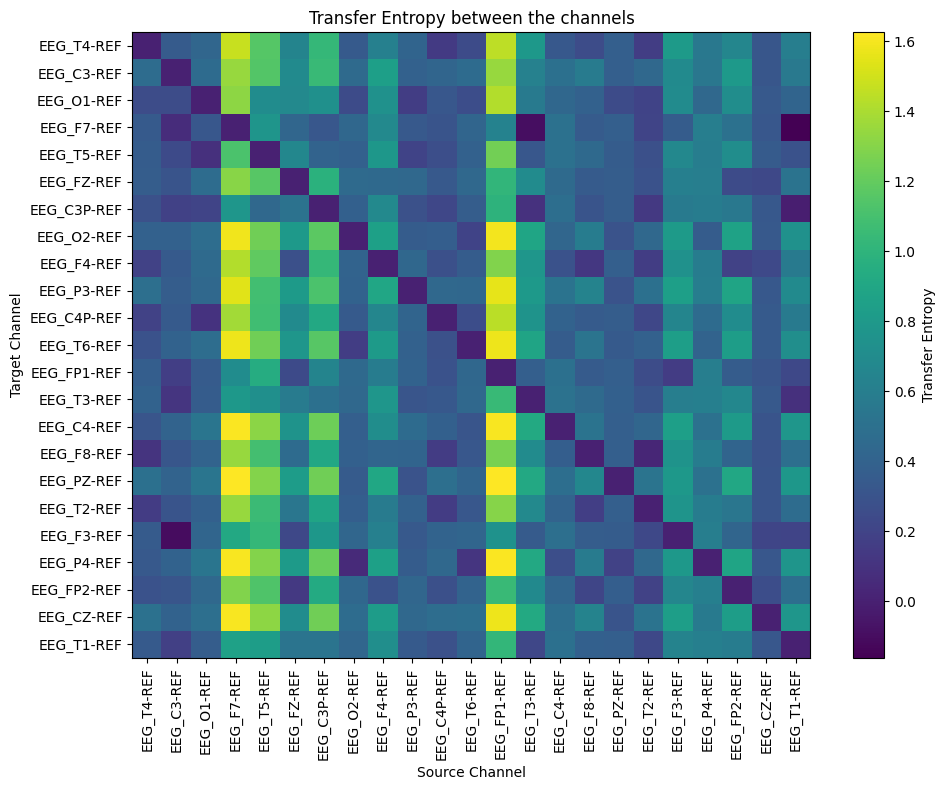

In [49]:
# Função para calcular entropia condicional
def conditional_entropy(x, y, bins=16):
    # Calcular o histograma conjunto
    joint_hist, _, _ = np.histogram2d(x, y, bins=bins, density=True)
    joint_prob = joint_hist / np.sum(joint_hist)  # Probabilidade conjunta
    marginal_y = np.sum(joint_prob, axis=0)  # Marginal para y
    
    # Ajustar probabilidades condicionais
    conditional_prob = np.divide(
        joint_prob, 
        marginal_y[np.newaxis, :],  # Adicionar nova dimensão para broadcast correto
        out=np.zeros_like(joint_prob), 
        where=marginal_y[np.newaxis, :] != 0  # Evitar divisões por zero
    )
    
    # Calcular entropia condicional
    valid_probs = joint_prob * np.log2(conditional_prob + 1e-12)
    valid_probs = valid_probs[np.isfinite(valid_probs)]  # Excluir valores não finitos
    return -np.sum(valid_probs)

# Função para calcular entropia de transferência
def transfer_entropy(x, y, bins=16):
    return conditional_entropy(y[1:], x[:-1], bins) - conditional_entropy(y[1:], y[:-1], bins)

# Diretório e exclusões
processed_dir = '/Users/analuiza/Documents/codes/templedata/00007656_s010_t000_processed_data'
processed_files = [
    f for f in os.listdir(processed_dir) if f.endswith('.npy') and not any(exc in f for exc in excluded_channels)
]

# Carregar sinais
signals = []
channel_names = []
for file in processed_files:
    signal = np.load(os.path.join(processed_dir, file))
    signals.append(signal)
    channel_names.append(file.replace('.npy', ''))

# Calcular entropia de transferência entre canais
n_channels = len(signals)
te_matrix = np.zeros((n_channels, n_channels))

for i in range(n_channels):
    for j in range(n_channels):
        if i != j:  # Evitar diagonal principal
            te_matrix[i, j] = transfer_entropy(signals[i], signals[j])

# Plotar a matriz de Entropia de Transferência
plt.figure(figsize=(10, 8))
plt.imshow(te_matrix, cmap='viridis', aspect='auto')
plt.colorbar(label='Transfer Entropy')
plt.xticks(ticks=np.arange(n_channels), labels=channel_names, rotation=90)
plt.yticks(ticks=np.arange(n_channels), labels=channel_names)
plt.title('Transfer Entropy between the channels')
plt.xlabel('Source Channel')
plt.ylabel('Target Channel')
plt.tight_layout()
plt.show()

Creating RawArray with float64 data, n_channels=19, n_times=258048
    Range : 0 ... 258047 =      0.000 ...  1007.996 secs
Ready.


MovieWriter imagemagick unavailable; using Pillow instead.


Mapeamento dinâmico sem grade salvo como GIF.


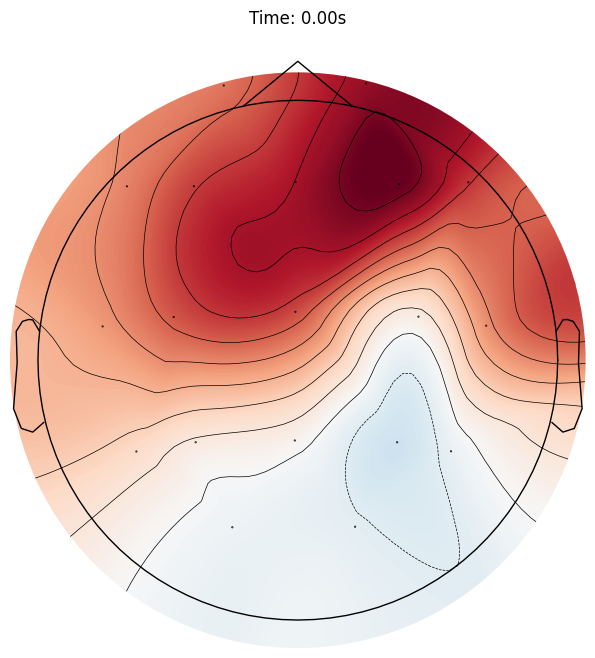

In [32]:
# Localizações padrão dos canais (10-20)
montage = mne.channels.make_standard_montage('standard_1020')

# Mapear os nomes dos canais para o padrão 10-20
channel_mapping = {
    'EEG_FP1-REF': 'Fp1', 'EEG_FP2-REF': 'Fp2', 'EEG_F7-REF': 'F7', 'EEG_F3-REF': 'F3',
    'EEG_FZ-REF': 'Fz', 'EEG_F4-REF': 'F4', 'EEG_F8-REF': 'F8', 'EEG_T3-REF': 'T3',
    'EEG_C3-REF': 'C3', 'EEG_CZ-REF': 'Cz', 'EEG_C4-REF': 'C4', 'EEG_T4-REF': 'T4',
    'EEG_T5-REF': 'T5', 'EEG_P3-REF': 'P3', 'EEG_PZ-REF': 'Pz', 'EEG_P4-REF': 'P4',
    'EEG_T6-REF': 'T6', 'EEG_O1-REF': 'O1', 'EEG_O2-REF': 'O2'
}

# Carregar dados processados
channel_files = [f for f in os.listdir(output_dir) if f.endswith('.npy')]
channel_names = [f.replace('.npy', '') for f in channel_files]

# Filtrar apenas os canais mapeáveis
valid_channels = [ch for ch in channel_names if ch in channel_mapping]
data = []
for ch in valid_channels:
    signal = np.load(os.path.join(output_dir, f"{ch}.npy"))
    data.append(signal)
data = np.array(data)  # [n_canais x n_amostras]

# Criar objeto RawArray com os dados carregados
mapped_channel_names = [channel_mapping[ch] for ch in valid_channels]
info = mne.create_info(ch_names=mapped_channel_names, sfreq=sfreq, ch_types='eeg')
raw = mne.io.RawArray(data, info)

# Aplicar montagem padrão (10-20)
raw.set_montage(montage)

# Gerar animação manualmente
times = np.linspace(0, raw.times[-1], 200)  # 50 frames ao longo do tempo

# Criar a figura para a animação
fig, ax = plt.subplots(figsize=(8, 8))  # Ajustar o tamanho do gráfico

# Função para atualizar os frames
def update_topomap(frame_idx):
    ax.clear()
    time_point = times[frame_idx]
    data_point = raw.get_data(tmin=time_point, tmax=time_point + 1/raw.info['sfreq'])[..., 0]
    mne.viz.plot_topomap(
        data_point,
        raw.info,
        axes=ax,
        show=False,
        cmap="RdBu_r",  # Colormap adequado
        contours=10,  # Número de contornos no mapa
        sphere=None  # Sem grade de EEG
    )
    ax.set_title(f"Time: {time_point:.2f}s", fontsize=12)

# Criar a animação
ani = FuncAnimation(fig, update_topomap, frames=len(times), interval=100)
ani.save('/Users/analuiza/Documents/codes/templedata/mapeamento_dinamico.gif', writer='imagemagick')
print("Mapeamento dinâmico sem grade salvo como GIF.")

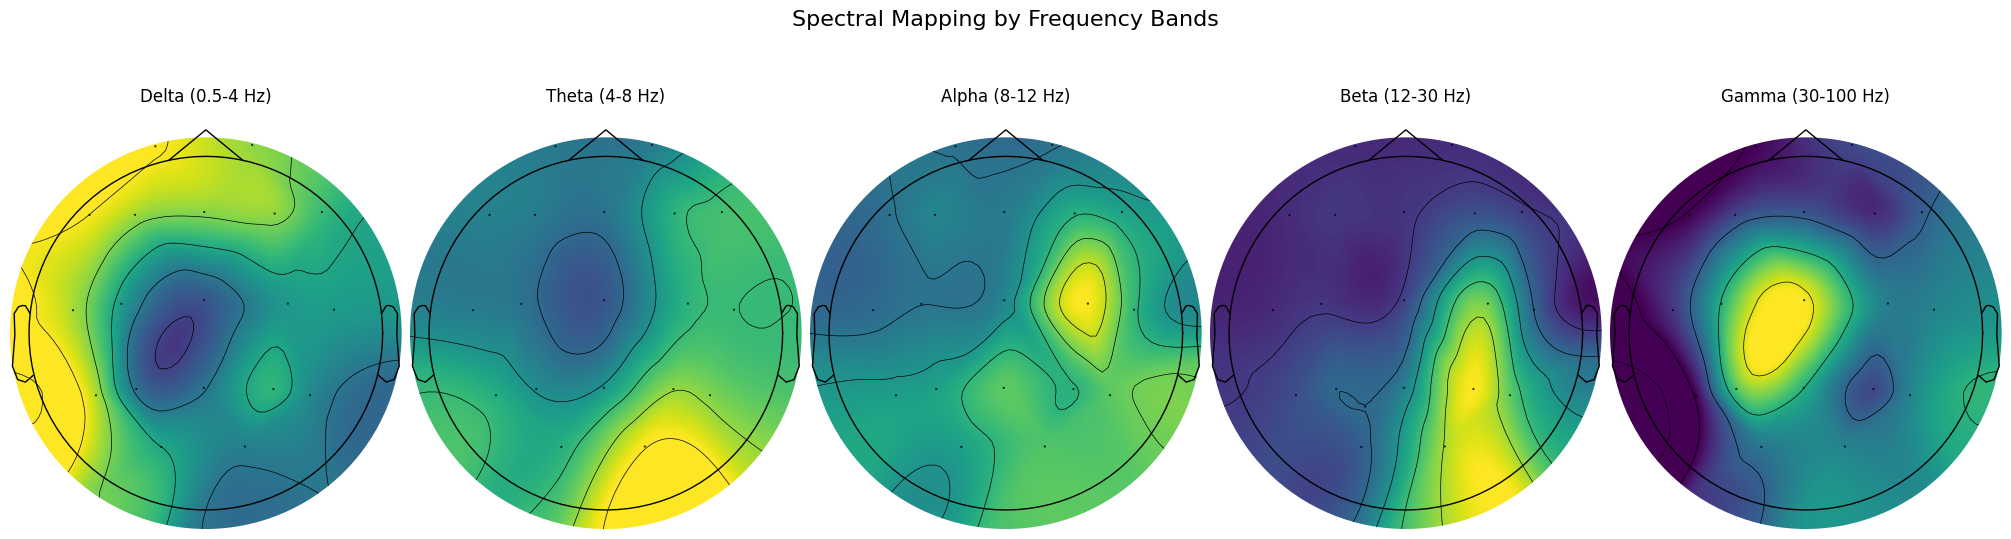

In [33]:
# Definir as bandas de frequência
bands = {
    "Delta (0.5-4 Hz)": (0.5, 4),
    "Theta (4-8 Hz)": (4, 8),
    "Alpha (8-12 Hz)": (8, 12),
    "Beta (12-30 Hz)": (12, 30),
    "Gamma (30-100 Hz)": (30, 100),
}

# Frequência de amostragem (sfreq) obtida dos dados
sfreq = raw.info['sfreq']

# Realizar a FFT e calcular a potência para cada banda
n_channels = len(raw.ch_names)
fft_data = np.abs(np.fft.rfft(raw.get_data(), axis=1))**2  # Potência
freqs = np.fft.rfftfreq(raw.get_data().shape[1], d=1/sfreq)  # Frequências associadas

# Criar dicionário para armazenar as potências por banda
band_powers = {band: [] for band in bands}

for band, (low, high) in bands.items():
    # Selecionar índices de frequência dentro da banda
    idx_band = np.where((freqs >= low) & (freqs <= high))[0]
    # Média da potência dentro da banda
    band_powers[band] = fft_data[:, idx_band].mean(axis=1)

# Criar o mapeamento cerebral para cada banda
fig, axes = plt.subplots(1, len(bands), figsize=(20, 6), constrained_layout=True)
for ax, (band, power) in zip(axes, band_powers.items()):
    mne.viz.plot_topomap(
        power, raw.info, axes=ax, show=False, cmap="viridis", contours=5
    )
    ax.set_title(band, fontsize=12)

# Exibir os mapas
plt.suptitle("Spectral Mapping by Frequency Bands", fontsize=16)
plt.show()

In [35]:
# Configuração do diretório de saída
output_dir = os.path.join('output_processing')
os.makedirs(output_dir, exist_ok=True)

# Função para carregar e normalizar os dados EEG
def load_and_normalize(processed_dir):
    files = [f for f in os.listdir(processed_dir) if f.endswith('.npy')]
    data = []
    for file in tqdm(files, desc="Loading EEG Channels"):
        data_path = os.path.join(processed_dir, file)
        channel_data = np.load(data_path)
        if channel_data.size < 2:
            print(f"Arquivo {file} contém poucos dados. Pulando...")
            continue
        data.append(channel_data)
    data = np.array(data)
    return data

# Função para realizar PCA
def apply_pca(data, n_components=5):
    pca = PCA(n_components=n_components)
    pca_components = pca.fit_transform(data.T)
    explained_variance = pca.explained_variance_ratio_
    return pca_components.T, explained_variance

# Função para realizar ICA
def apply_ica(data, n_components=5):
    ica = FastICA(n_components=n_components, random_state=42)
    ica_components = ica.fit_transform(data.T).T
    return ica_components

# Função para plotar os componentes
def plot_components(components, title, output_file, sampling_rate=256):
    time = np.linspace(0, components.shape[1] / sampling_rate, components.shape[1])
    plt.figure(figsize=(10, 6))
    for i, comp in enumerate(components, start=1):
        plt.plot(time, comp + i * 2, label=f'Component {i}')  # Offset para separar as curvas
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.tight_layout()
    plt.savefig(output_file, dpi=300)
    plt.close()

# Função para plotar a explicação da variância do PCA
def plot_pca_variance(explained_variance, output_file):
    plt.figure(figsize=(8, 5))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance * 100)
    plt.title('PCA Explained Variance')
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained (%)')
    plt.tight_layout()
    plt.savefig(output_file, dpi=300)
    plt.close()

# Carregar e normalizar os dados
data = load_and_normalize(processed_dir)

# Aplicar PCA
pca_components, explained_variance = apply_pca(data, n_components=5)
plot_components(
    pca_components,
    title='PCA Components',
    output_file=os.path.join(output_dir, 'pca_components.png')
)
plot_pca_variance(
    explained_variance,
    output_file=os.path.join(output_dir, 'pca_variance.png')
)

# Aplicar ICA
ica_components = apply_ica(data, n_components=5)
plot_components(
    ica_components,
    title='ICA Components',
    output_file=os.path.join(output_dir, 'ica_components.png')
)

Loading EEG Channels: 100%|██████████| 23/23 [00:00<00:00, 547.93it/s]


1. Validação da Interpretação: Identificar Regiões Específicas dos Eletrodos

Os eletrodos específicos mencionados nos metadados são C4, T6 e T4 (quadrante posterior direito). Para validar, podemos mapear os componentes ICA em função dessas regiões específicas.

In [36]:
# Mapeamento dos componentes ICA para os canais
def validate_ica_with_regions(ica_components, electrode_mapping, electrode_targets):
    """
    Correlaciona os componentes ICA com os eletrodos-alvo.

    :param ica_components: Componentes independentes extraídos (ICA).
    :param electrode_mapping: Mapeamento dos canais para eletrodos (10-20 system).
    :param electrode_targets: Eletrodos específicos a analisar (C4, T6, T4).
    :return: Correlação entre componentes ICA e os eletrodos-alvo.
    """
    results = {}
    for i, comp in enumerate(ica_components):
        for target in electrode_targets:
            if target in electrode_mapping:
                electrode_index = electrode_mapping[target]
                correlation = np.corrcoef(comp, data[electrode_index])[0, 1]
                results[f'Component {i+1} - {target}'] = correlation
    return results


# Exemplo de mapeamento e eletrodos de interesse
electrode_mapping = {
    'C4': 0,  # Índice hipotético no array de dados
    'T6': 1,
    'T4': 2
}
electrode_targets = ['C4', 'T6', 'T4']

# Avaliação da correlação
correlations = validate_ica_with_regions(ica_components, electrode_mapping, electrode_targets)
print("Correlação dos componentes ICA com os eletrodos-alvo:")
for key, value in correlations.items():
    print(f"{key}: {value:.2f}")

Correlação dos componentes ICA com os eletrodos-alvo:
Component 1 - C4: 0.43
Component 1 - T6: -0.18
Component 1 - T4: -0.05
Component 2 - C4: -0.06
Component 2 - T6: 0.45
Component 2 - T4: 0.08
Component 3 - C4: -0.06
Component 3 - T6: -0.22
Component 3 - T4: 0.07
Component 4 - C4: -0.54
Component 4 - T6: -0.67
Component 4 - T4: 0.47
Component 5 - C4: 0.70
Component 5 - T6: 0.41
Component 5 - T4: 0.83


2. Separação de Artefatos: Avaliar Componentes ICA

Para identificar componentes relacionados a artefatos (ruído ou movimento), podemos:
	•	Verificar correlações com eletrodos “suspeitos”.
	•	Examinar componentes com padrões repetitivos incomuns.

Componentes ICA suspeitos de serem artefatos: [2]


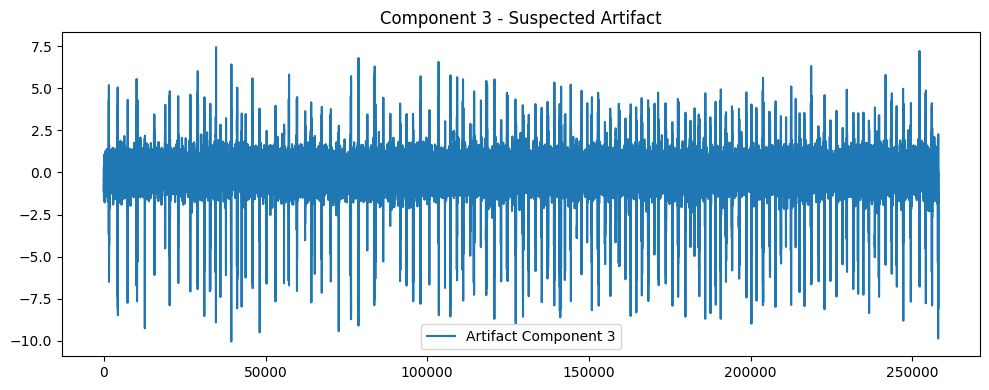

In [37]:
# Função para avaliar artefatos em componentes ICA
def detect_artifacts(ica_components, threshold=0.8):
    """
    Identifica componentes suspeitos de serem artefatos com base em sua amplitude.

    :param ica_components: Componentes independentes extraídos (ICA).
    :param threshold: Amplitude máxima considerada aceitável para descartar artefatos.
    :return: Lista de índices de componentes suspeitos.
    """
    artifacts = []
    for i, comp in enumerate(ica_components):
        if np.max(np.abs(comp)) > threshold:
            artifacts.append(i)
    return artifacts

# Detectar componentes suspeitos
artifact_components = detect_artifacts(ica_components, threshold=10)  # Ajuste do limiar
print("Componentes ICA suspeitos de serem artefatos:", artifact_components)

# Visualizar componentes suspeitos
for idx in artifact_components:
    plt.figure(figsize=(10, 4))
    plt.plot(ica_components[idx], label=f'Artifact Component {idx+1}')
    plt.title(f'Component {idx+1} - Suspected Artifact')
    plt.legend()
    plt.tight_layout()
    plt.show()

3. Foco na Epilepsia: Estudo dos Picos Repetitivos

Para capturar padrões epileptiformes, extraímos os padrões com alta frequência temporal (picos e polipicos) relacionados às regiões-alvo.

Component 1: 606 spikes detected


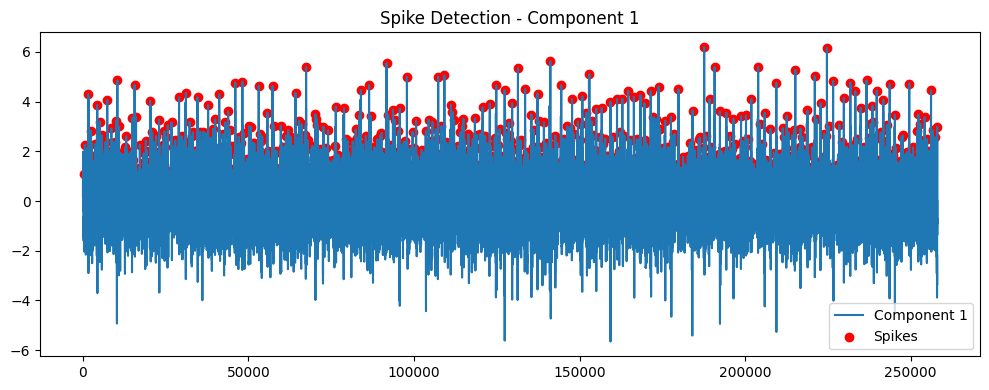

Component 2: 617 spikes detected


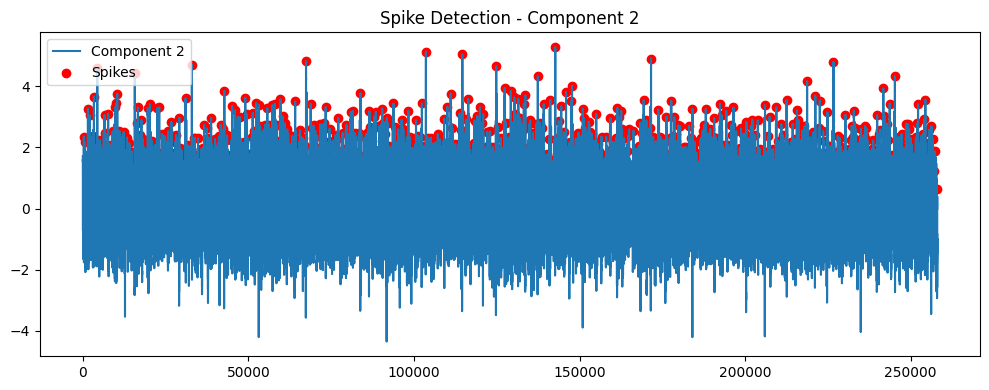

Component 3: 614 spikes detected


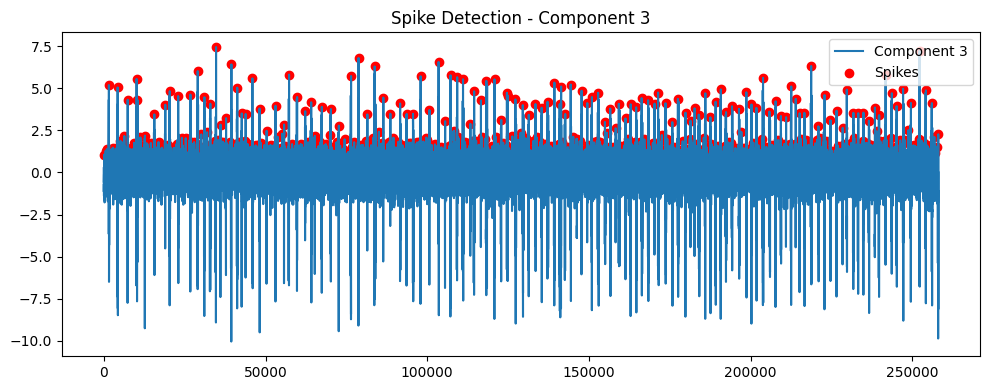

Component 4: 767 spikes detected


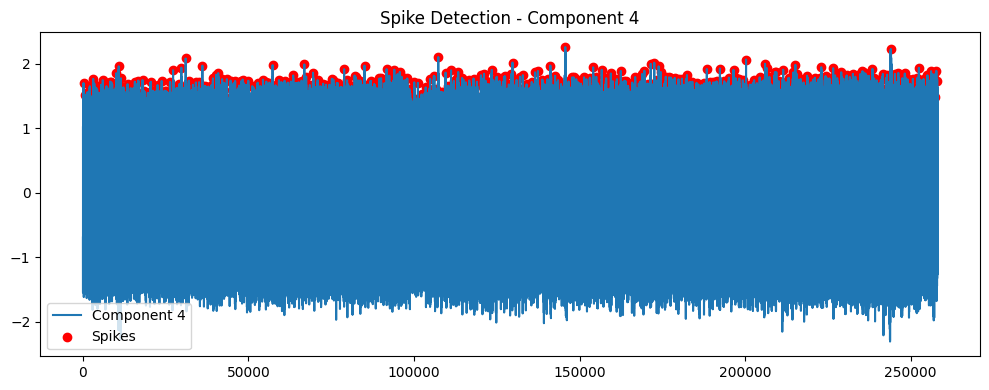

Component 5: 597 spikes detected


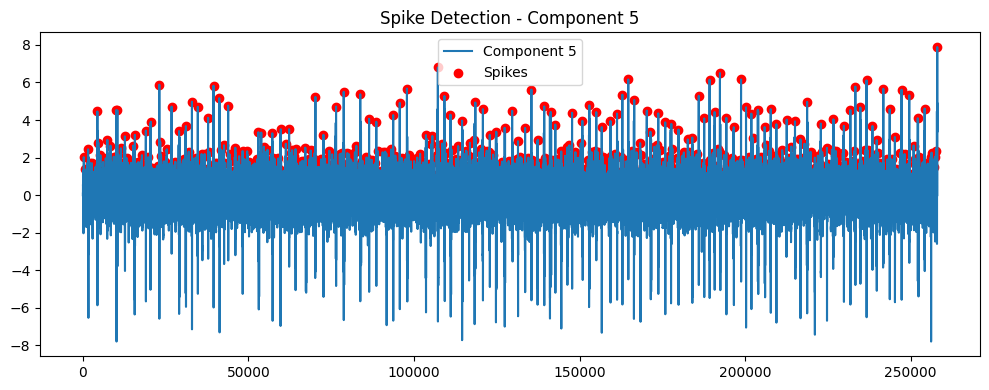

In [38]:
# Função para detectar picos nos componentes ICA
from scipy.signal import find_peaks

def detect_spike_patterns(component, distance=256, prominence=1):
    """
    Detecta picos repetitivos em um componente.

    :param component: Componente ICA a ser analisado.
    :param distance: Distância mínima entre picos (amostras).
    :param prominence: Proeminência mínima do pico.
    :return: Índices dos picos detectados.
    """
    peaks, _ = find_peaks(component, distance=distance, prominence=prominence)
    return peaks

# Detectar picos nos componentes relacionados a C4, T6, T4
for idx, comp in enumerate(ica_components):
    peaks = detect_spike_patterns(comp, distance=256, prominence=2)  # Ajustar parâmetros
    print(f"Component {idx+1}: {len(peaks)} spikes detected")
    plt.figure(figsize=(10, 4))
    plt.plot(comp, label=f'Component {idx+1}')
    plt.scatter(peaks, comp[peaks], color='red', label='Spikes')
    plt.title(f'Spike Detection - Component {idx+1}')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [57]:
import seaborn as sns

# Função para calcular e plotar a matriz de conectividade
def process_connectivity(processed_dir, output_dir):
    files = [f for f in os.listdir(processed_dir) if f.endswith('.npy')]

    # Carregar todos os sinais
    data = [np.load(os.path.join(processed_dir, f)) for f in files]
    data = np.array(data)  # Formato: canais x amostras

    # Calcular a matriz de correlação
    connectivity_matrix = np.corrcoef(data)

    # Plotar a matriz
    plt.figure(figsize=(10, 8))
    sns.heatmap(connectivity_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Functional Connectivity (Correlation)")
    plt.xlabel("Channels")
    plt.ylabel("Channels")
    plt.tight_layout()

    # Salvar a imagem
    output_file = os.path.join(output_dir, "connectivity_matrix.png")
    plt.savefig(output_file, dpi=300)
    plt.close()

# Executar o processamento
process_connectivity(processed_dir, output_dir)

In [66]:
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns

# Diretórios de entrada e saída
output_dir = os.path.join('output_processing')
os.makedirs(output_dir, exist_ok=True)

# Função para calcular a matriz de conectividade
def calculate_connectivity(data):
    return np.corrcoef(data)

# Função para construir o grafo e calcular métricas
def build_and_analyze_graph(connectivity_matrix, electrode_labels, output_dir):
    # Criar o grafo
    G = nx.Graph()

    # Adicionar nós
    for label in electrode_labels:
        G.add_node(label)

    # Adicionar arestas com base na conectividade
    edges = []
    weights = []
    for i in range(len(electrode_labels)):
        for j in range(i+1, len(electrode_labels)):
            weight = connectivity_matrix[i, j]
            if abs(weight) > 0.5:  # Limite para criar arestas
                G.add_edge(electrode_labels[i], electrode_labels[j], weight=weight)
                edges.append((electrode_labels[i], electrode_labels[j]))
                weights.append(weight)

    # Configuração de normalização para cores e espessuras
    norm = Normalize(vmin=min(weights), vmax=max(weights))
    cmap = plt.cm.viridis
    edge_widths = [2.5 * abs(w) for w in weights]  # Espessura baseada no peso

    # Configurar tamanhos dos nós
    node_size_base = 2000  # Base para garantir espaço suficiente para o texto
    node_sizes = [node_size_base for _ in G.nodes()]  # Todos os nós do mesmo tamanho

    # Visualizar o grafo
    fig, ax = plt.subplots(figsize=(18, 15))
    pos = nx.spring_layout(G, seed=42, k=0.4)  # Ajustar para evitar sobreposição
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_sizes, node_color='skyblue', edgecolors='k')
    nx.draw_networkx_labels(
        G, pos, ax=ax, font_size=7, font_weight='bold', verticalalignment='center', horizontalalignment='center'
    )
    nx.draw_networkx_edges(
        G, pos, ax=ax, edgelist=edges,
        edge_color=[cmap(norm(w)) for w in weights],
        width=edge_widths
    )

    # Adicionar barra de cores manualmente
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
    cbar.set_label("Connectivity Strength", fontsize=14)

    ax.set_title("Enhanced Functional Connectivity Graph", fontsize=20, fontweight="bold")
    plt.tight_layout()

    # Salvar o grafo
    graph_file = os.path.join(output_dir, "enhanced_connectivity_graph_readable.png")
    plt.savefig(graph_file, dpi=300)
    plt.close()

# Função principal para processar os dados e gerar a rede
def process_network_analysis(processed_dir, output_dir):
    files = [f for f in os.listdir(processed_dir) if f.endswith('.npy')]

    # Carregar dados e calcular matriz de conectividade
    data = [np.load(os.path.join(processed_dir, f)) for f in files]
    data = np.array(data)  # Formato: canais x amostras
    electrode_labels = [f"Channel {i+1}" for i in range(len(data))]

    connectivity_matrix = calculate_connectivity(data)

    # Plotar a matriz de conectividade
    plt.figure(figsize=(10, 8))
    sns.heatmap(connectivity_matrix, xticklabels=electrode_labels, yticklabels=electrode_labels, annot=False, cmap='coolwarm')
    plt.title("Connectivity Matrix", fontsize=16, fontweight="bold")
    plt.tight_layout()
    heatmap_file = os.path.join(output_dir, "connectivity_matrix.png")
    plt.savefig(heatmap_file, dpi=300)
    plt.close()

    # Construir e analisar o grafo
    build_and_analyze_graph(connectivity_matrix, electrode_labels, output_dir)

# Executar o processamento
process_network_analysis(processed_dir, output_dir)

In [39]:
'''

# Diretório de saída
output_dir = os.path.join('output_processing')
os.makedirs(output_dir, exist_ok=True)

# Função para aplicar a Transformada Wavelet Contínua (CWT) em blocos
def apply_cwt_blocked(data, sampling_rate, wavelet='morl', scales=None, block_size=1024):
    if scales is None:
        scales = np.arange(1, 50)  # Frequências típicas do EEG
    results = []
    for start in range(0, len(data), block_size):
        block = data[start:start + block_size]
        if len(block) < 2:
            continue
        coeffs, freqs = pywt.cwt(block, scales, wavelet, 1 / sampling_rate)
        results.append(coeffs)
    return np.hstack(results), freqs

# Processar arquivos de EEG
def process_eeg_files(processed_dir, output_dir, wavelet='morl', block_size=1024):
    files = [f for f in os.listdir(processed_dir) if f.endswith('.npy')]
    for file in tqdm(files, desc="Processing EEG Channels"):
        data_path = os.path.join(processed_dir, file)
        channel_data = np.load(data_path)

        # Visualizar o sinal original
        plt.figure(figsize=(10, 4))
        plt.plot(channel_data, label='Original Signal')
        plt.title(f'Signal - {file}')
        plt.xlabel('Samples')
        plt.ylabel('Amplitude')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'{os.path.splitext(file)[0]}_signal.png'))
        plt.close()

        if channel_data.size < 2:
            print(f"Arquivo {file} contém poucos dados. Pulando...")
            continue

        # Aplicar CWT em blocos
        try:
            sampling_rate = 256
            coeffs, freqs = apply_cwt_blocked(channel_data, sampling_rate, wavelet, block_size=block_size)
        except Exception as e:
            print(f"Erro ao processar {file}: {e}")
            continue

        # Salvar coeficientes em arquivo
        np.save(os.path.join(output_dir, f'{file}_cwt.npy'), coeffs)
        plot_spectral_cwt(coeffs, freqs, sampling_rate, file, output_dir)

# Função para plotar o espectrograma
def plot_spectral_cwt(coeffs, freqs, sampling_rate, file_name, output_dir):
    time = np.linspace(0, coeffs.shape[1] / sampling_rate, coeffs.shape[1])
    power = np.abs(coeffs) ** 2

    plt.figure(figsize=(8, 5), dpi=80)  # Gráficos com menor DPI para reduzir memória
    plt.pcolormesh(time, freqs, np.log1p(power), shading='gouraud', cmap='viridis', vmin=0, vmax=5)
    plt.colorbar(label='Log Power')
    plt.title(f'Spectral CWT - {file_name}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.yscale('log')  # Escala logarítmica
    plt.tight_layout()

    output_path = os.path.join(output_dir, f'{os.path.splitext(file_name)[0]}_spectral_cwt.png')
    plt.savefig(output_path, dpi=80)  # Menor DPI para gráficos
    plt.close()


# Executar o processamento
process_eeg_files(processed_dir, output_dir)

'''

'\n\n# Diretório de saída\noutput_dir = os.path.join(\'output_processing\')\nos.makedirs(output_dir, exist_ok=True)\n\n# Função para aplicar a Transformada Wavelet Contínua (CWT) em blocos\ndef apply_cwt_blocked(data, sampling_rate, wavelet=\'morl\', scales=None, block_size=1024):\n    if scales is None:\n        scales = np.arange(1, 50)  # Frequências típicas do EEG\n    results = []\n    for start in range(0, len(data), block_size):\n        block = data[start:start + block_size]\n        if len(block) < 2:\n            continue\n        coeffs, freqs = pywt.cwt(block, scales, wavelet, 1 / sampling_rate)\n        results.append(coeffs)\n    return np.hstack(results), freqs\n\n# Processar arquivos de EEG\ndef process_eeg_files(processed_dir, output_dir, wavelet=\'morl\', block_size=1024):\n    files = [f for f in os.listdir(processed_dir) if f.endswith(\'.npy\')]\n    for file in tqdm(files, desc="Processing EEG Channels"):\n        data_path = os.path.join(processed_dir, file)\n    